In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
from lesanalysis import *

### Set test and reference cases

In [2]:
palmcase     = '/users/qingli/scratch3/palm_gpu_hackathon/test/RUN_pgi.kodiak_mpirun_PALM_ocean_MSM97-LT'
palmcase_ref = '/users/qingli/scratch3/palm/jobs/RUN_ifort.grizzly_hdf5_mpirun_PALM_ocean_MSM97-LT'
# palmcase_ref = '/users/qingli/scratch3/palm_gpu_hackathon/test/RUN_ifort.grizzly_hdf5_mpirun_PALM_ocean_MSM97-LT'

In [3]:
inputfile_pfl     = palmcase+'/DATA_1D_PR_NETCDF'
inputfile_pfl_ref = palmcase_ref+'/DATA_1D_PR_NETCDF'
data_pfl          = PALMData1DPR(inputfile_pfl)
data_pfl_ref      = PALMData1DPR(inputfile_pfl_ref)

### Parameters

In [4]:
# flags
f_ref = True
f_norm = True

In [5]:
# Gravitational acceleration (m/s^2)
g = 9.81
# Latitude
lat = 45.0
# Coriolis parameter (1/s)
f = 4*np.pi/86400*np.sin(lat/180*np.pi)
# friction velocity (m/s)
ustar = 6.1e-3
# surface temperature flux (K m/s)
Q0 = 1.19e-6
# reference density
rho_0 = 1027.0
# depth of the domain (m)
depth = -120.0
# spin-up time (s)
tspinup = 21600.

### Plot profiles

- z

In [6]:
# range of z
if f_norm:
    ylabel_str = r'$z/h_b$'
    ymin = -1.6
    ymax = 0
else:
    ylabel_str = 'Depth (m)'
    ymin = depth
    ymax = 0

- Time

In [7]:
# mean profile over the last inertial period
time = data_pfl.dataset.variables['time'][:]
deltat = 2*np.pi/f # one inertial period
ttarget = time[-1]-deltat
assert ttarget>tspinup, 'Run time too short for average over the last inertial period.'
tidx_start = np.argmin(np.abs(time-ttarget))
tidx_end = -1

if f_ref:
    time_ref = data_pfl_ref.dataset.variables['time'][:]
    ttarget_ref = time_ref[-1]-deltat
    assert ttarget_ref>tspinup, 'Reference run time too short for average over the last inertial period.'
    tidx_start_ref = np.argmin(np.abs(time_ref-ttarget_ref))
    tidx_end_ref = -1

- Initial temperature and salinity profiles

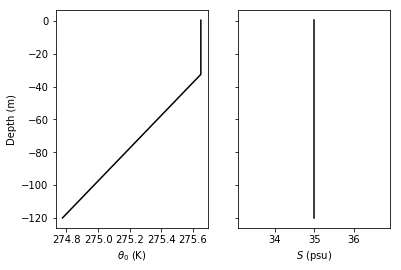

In [8]:
# plot
fig, axarr = plt.subplots(1, 2, sharey='row')
data_pfl.read_profile('pt', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[0], color='k', xlabel=r'$\theta_0$ (K)', ylabel='Depth (m)')
data_pfl.read_profile('sa', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[1], color='k', xlabel=r'$S$ (psu)', ylabel='off')

if f_ref:
    data_pfl_ref.read_profile('pt', tidx_start=0, tidx_end=1).plot_mean(
                               axis=axarr[0], color='k', 
                               xlabel='off', ylabel='off', linestyle='--')
    data_pfl_ref.read_profile('sa', tidx_start=0, tidx_end=1).plot_mean(
                               axis=axarr[1], color='k',
                               xlabel='off', ylabel='off', linestyle='--')
    

- Temperature and salinity profiles at the end of the simulation

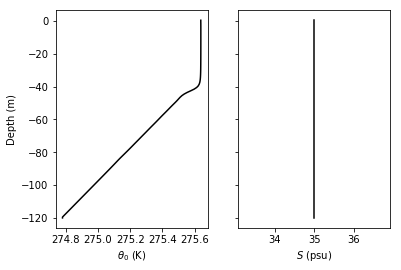

In [9]:
# plot
fig, axarr = plt.subplots(1, 2, sharey='row')
data_pfl.read_profile('pt', tidx_start=-1).plot_mean(
                           axis=axarr[0], color='k', xlabel=r'$\theta_0$ (K)', ylabel='Depth (m)')
data_pfl.read_profile('sa', tidx_start=-1).plot_mean(
                           axis=axarr[1], color='k', xlabel=r'$S$ (psu)', ylabel='off')

if f_ref:
    data_pfl_ref.read_profile('pt', tidx_start=-1).plot_mean(
                               axis=axarr[0], color='k',
                               xlabel='off', ylabel='off', linestyle='--')
    data_pfl_ref.read_profile('sa', tidx_start=-1).plot_mean(
                               axis=axarr[1], color='k',
                               xlabel='off', ylabel='off', linestyle='--')
    

- Mean boundary layer depth defined by the depth where N^2 reaches maximum

h_b =  41.38 m


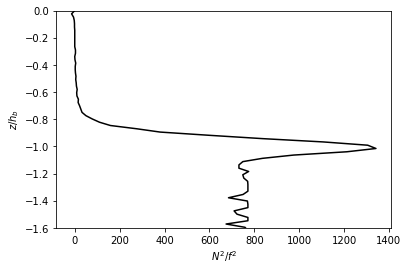

In [10]:
# normalizaing factor
if f_norm:
    norm = 1/f**2
    xlabel_str = r'$N^2/f^2$'
else:
    norm = 1
    xlabel_str = r'$N^2$ (s$^{-2}$)'

# plot
prho = data_pfl.read_profile('prho', tidx_start=tidx_start, tidx_end=tidx_end)
NN_data = -g*(prho.data[:,1:]-prho.data[:,0:-1])/(prho.z[1:]-prho.z[0:-1])/rho_0
NN_z = 0.5*(prho.z[1:]+prho.z[0:-1])
NN = LESProfile(data=NN_data, data_name=r'$N^2$', data_units=r's$^{-2}$', z=NN_z, time=time[tidx_start:tidx_end])
zidx = np.argmax(NN.data, axis=1)
hb = np.abs(NN.z[zidx].mean())
print('h_b = {:6.2f} m'.format(hb))
if f_norm:
    znorm = 1/hb
else:
    znorm = 1
NN.plot_mean(norm=norm, znorm=znorm, color='k', xlabel=xlabel_str, ylabel=ylabel_str, ylim=[ymin, ymax])

if f_ref:
    prho = data_pfl_ref.read_profile('prho', tidx_start=tidx_start, tidx_end=tidx_end)
    NN_data = -g*(prho.data[:,1:]-prho.data[:,0:-1])/(prho.z[1:]-prho.z[0:-1])/rho_0
    NN_z = 0.5*(prho.z[1:]+prho.z[0:-1])
    NN_ref = LESProfile(data=NN_data, data_name=r'$N^2$', data_units=r's$^{-2}$', z=NN_z, time=time[tidx_start:tidx_end])
    zidx = np.argmax(NN.data, axis=1)
    hb_ref = np.abs(NN_ref.z[zidx].mean())
    print('h_b_ref = {:6.2f} m'.format(hb_ref))
    if f_norm:
        znorm_ref = 1/hb_ref
    else:
        znorm_ref = 1
    NN_ref.plot_mean(norm=norm, znorm=znorm_ref, color='k', xlabel='off', ylabel='off', linestyle='--')

#### - Temperature variance

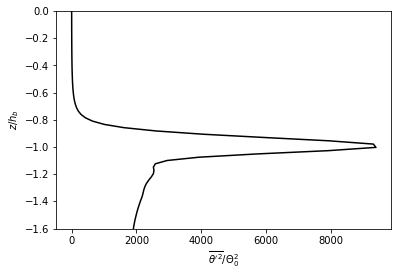

In [11]:
# normalizing factor
if f_norm:
    norm = 1/(Q0/ustar)**2
    xlabel_str = r'$\overline{{\theta^\prime}^2}/\Theta_0^2$'
else:
    norm = 1
    xlabel_str = r'$\overline{{\theta^\prime}^2}$ (K$^2$)'

# plot
data_pfl.read_profile('pt*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                              norm=norm, znorm=znorm, color='k',
                              xlabel=xlabel_str,
                              ylabel=ylabel_str, ylim=[ymin, ymax])

if f_ref:
    data_pfl_ref.read_profile('pt*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                      norm=norm, znorm=znorm_ref, color='k',
                                      xlabel='off', ylabel='off', linestyle='--')
    

- Temperature fluxes

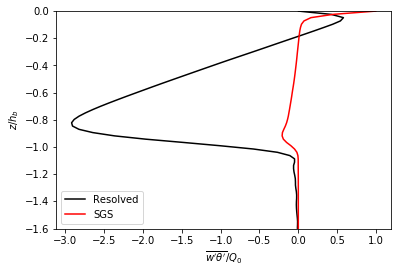

In [12]:
# normalizing factor
if f_norm:
    norm = 1/Q0
    xlabel_str = r'$\overline{w^\prime \theta^\prime}/Q_0$'
else:
    norm = 1
    xlabel_str = r'$\overline{w^\prime \theta^\prime}$ (K m s$^{-1}$)'

# plot
data_pfl.read_profile('w*pt*', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                               norm=norm, znorm=znorm, color='k',
                               xlabel=xlabel_str,
                               ylabel=ylabel_str, ylim=[ymin, ymax], label='Resolved')
data_pfl.read_profile('w"pt"', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                               norm=norm, znorm=znorm, color='r',
                               xlabel='off', ylabel='off', label='SGS')
plt.legend(loc=3)

if f_ref:
    data_pfl_ref.read_profile('w*pt*', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                       norm=norm, znorm=znorm_ref, color='k',
                                       xlabel='off', ylabel='off', linestyle='--')
    data_pfl_ref.read_profile('w"pt"', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                       norm=norm, znorm=znorm_ref, color='r',
                                       xlabel='off', ylabel='off', linestyle='--')
    

- Mean velocity

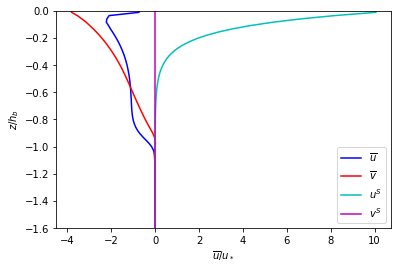

In [13]:
# normalizaing factor
if f_norm:
    norm = 1/ustar
    xlabel_str = r'$\overline{u}/u_*$'
else:
    norm = 1
    xlabel_str = r'$\overline{u}$ (m s$^{-1}$)'

data_pfl.read_profile('u', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm, color='b',
                             xlabel=xlabel_str,
                             ylabel=ylabel_str, ylim=[ymin, ymax], label='$\overline{u}$')
data_pfl.read_profile('v', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm, color='r',
                             xlabel='off', ylabel='off', label='$\overline{v}$')
try:
    data_pfl.read_profile('u_stk', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                   norm=norm, znorm=znorm, color='c',
                                   xlabel='off', ylabel='off', label='$u^S$')
    data_pfl.read_profile('v_stk', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                   norm=norm, znorm=znorm, color='m',
                                   xlabel='off', ylabel='off', label='$v^S$')
except ValueError:
    print('Stokes drift not found. Skip.')
    
plt.legend(loc=4)

if f_ref:
    data_pfl_ref.read_profile('u', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                 norm=norm, znorm=znorm_ref, color='b',
                                 xlabel='off', ylabel='off', linestyle='--')
    data_pfl_ref.read_profile('v', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                 norm=norm, znorm=znorm_ref, color='r',
                                 xlabel='off', ylabel='off', linestyle='--')
    try:
        data_pfl_ref.read_profile('u_stk', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                     norm=norm, znorm=znorm_ref, color='c',
                                     xlabel='off', ylabel='off', linestyle='--')
        data_pfl_ref.read_profile('v_stk', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                     norm=norm, znorm=znorm_ref, color='m',
                                     xlabel='off', ylabel='off', linestyle='--')
    except ValueError:
        print('Ref: Stokes drift not found. Skip.')
    
    

- Momentum fluxes

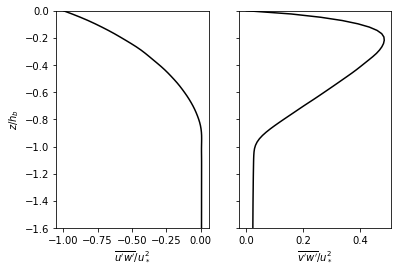

In [14]:
# normalizaing factor
if f_norm:
    norm = 1/ustar**2
    xlabel_str1 = r'$\overline{u^\prime w^\prime}/u_*^2$'
    xlabel_str2 = r'$\overline{v^\prime w^\prime}/u_*^2$'
else:
    norm = 1
    xlabel_str1 = r'$\overline{u^\prime w^\prime}$ (m$^2$ s$^{-2}$)'
    xlabel_str2 = r'$\overline{v^\prime w^\prime}$ (m$^2$ s$^{-2}$)'

# subplots
fig, axarr = plt.subplots(1, 2, sharey='row')
data_pfl.read_profile('wu', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                            axis=axarr[0], norm=norm, znorm=znorm, color='k',
                            xlabel=xlabel_str1, ylabel=ylabel_str, ylim=[ymin, ymax])
data_pfl.read_profile('wv', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                            axis=axarr[1], norm=norm, znorm=znorm, color='k',
                            xlabel=xlabel_str2, ylabel='off')

if f_ref:
    data_pfl_ref.read_profile('wu', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                    axis=axarr[0], norm=norm, znorm=znorm_ref,
                                    xlabel='off', ylabel='off', color='k', linestyle='--')
    data_pfl_ref.read_profile('wv', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                    axis=axarr[1], norm=norm, znorm=znorm_ref, 
                                    xlabel='off', ylabel='off', color='k', linestyle='--')

- Velocity variance

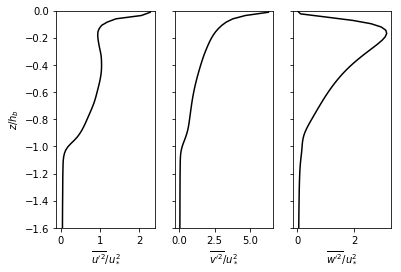

In [15]:
# normalizing factor
if f_norm:
    norm = 1/ustar**2
    xlabel_str1 = r'$\overline{{u^\prime}^2}/u_*^2$'
    xlabel_str2 = r'$\overline{{v^\prime}^2}/u_*^2$'
    xlabel_str3 = r'$\overline{{w^\prime}^2}/u_*^2$'
else:
    norm = 1
    xlabel_str1 = r'$\overline{{u^\prime}^2}$ (m$^2$ s$^{-2}$)'
    xlabel_str2 = r'$\overline{{v^\prime}^2}$ (m$^2$ s$^{-2}$)'
    xlabel_str3 = r'$\overline{{w^\prime}^2}$ (m$^2$ s$^{-2}$)'

# subplots
fig, axarr = plt.subplots(1, 3, sharey='row')
data_pfl.read_profile('u*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             axis=axarr[0], norm=norm, znorm=znorm, color='k',
                             xlabel=xlabel_str1, ylabel=ylabel_str, ylim=[ymin, ymax])
data_pfl.read_profile('v*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             axis=axarr[1], norm=norm, znorm=znorm, color='k',
                             xlabel=xlabel_str2, ylabel='off')
data_pfl.read_profile('w*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             axis=axarr[2], norm=norm, znorm=znorm, color='k',
                             xlabel=xlabel_str3, ylabel='off')

if f_ref:
    data_pfl_ref.read_profile('u*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                     axis=axarr[0], norm=norm, znorm=znorm_ref, color='k',
                                     xlabel='off',ylabel='off', linestyle='--')
    data_pfl_ref.read_profile('v*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                     axis=axarr[1], norm=norm, znorm=znorm_ref, color='k',
                                     xlabel='off',ylabel='off', linestyle='--')
    data_pfl_ref.read_profile('w*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                     axis=axarr[2], norm=norm, znorm=znorm_ref, color='k',
                                     xlabel='off',ylabel='off', linestyle='--')


- TKE

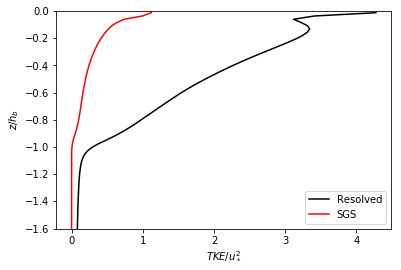

In [16]:
# normalizing factor
if f_norm:
    norm = 1/ustar**2
    xlabel_str = r'$TKE/u_*^2$'
else:
    norm = 1
    xlabel_str = r'$TKE$ (m$^2$ s$^{-2}$)'

e_res = data_pfl.read_profile('e*', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                    norm=norm, znorm=znorm, color='k',
                                    xlabel=xlabel_str, ylabel=ylabel_str,
                                    ylim=[ymin, ymax], label='Resolved')
e_sgs = data_pfl.read_profile('e', tidx_start=tidx_start, tidx_end=tidx_end)
e_sgs.z[0] = np.nan # fix the invalid depth of e at the bottom
e_sgs.plot_mean(norm=norm, znorm=znorm, color='r', xlabel='off', ylabel='off', label='SGS')
plt.legend(loc=4)

if f_ref:
    e_res = data_pfl_ref.read_profile('e*', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                            norm=norm, znorm=znorm_ref, color='k',
                                            xlabel='off', ylabel='off', linestyle='--')
    e_sgs = data_pfl_ref.read_profile('e', tidx_start=tidx_start, tidx_end=tidx_end)
    e_sgs.z[0] = np.nan # fix the invalid depth of e at the bottom
    e_sgs.plot_mean(norm=norm, znorm=znorm_ref, color='r', xlabel='off', ylabel='off', linestyle='--')
    

- Vertial velocity skewness

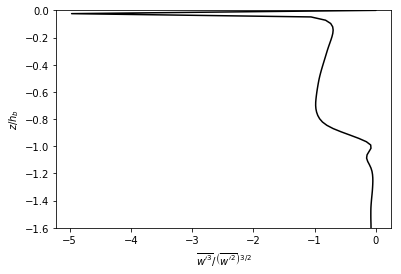

In [17]:
# normalizing factor
norm = 1

data_pfl.read_profile('Sw', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                            norm=norm, znorm=znorm, color='k',
                            xlabel=r'$\overline{{w^\prime}^3} / \left(\overline{{w^\prime}^2}\right)^{3/2}$',
                            ylabel=ylabel_str, ylim=[ymin, ymax])
if f_ref:
    data_pfl_ref.read_profile('Sw', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                                    norm=norm, znorm=znorm_ref, color='k',
                                    xlabel='off', ylabel='off', linestyle='--')